## Stable Diffusion fine tune with DreamBooth on SageMaker g4dn notebook
* Tested with ml.g4dn.xlarge SageMaker notebook, which has a NVIDIA T4 GPU with 16 GiB GPU memory.
* Content included training part and inference part.
* Major training codes were borrowed from [ShivamShrirao's repo](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth) and most of inference codes were borrowed from [Philschmid's blog](https://www.philschmid.de/sagemaker-stable-diffusion).

## 1. SageMaker training part

### 1.1 Install dependencies

In [1]:
%%writefile requirements.txt
accelerate
transformers>=4.25.1
ftfy
tensorboard
modelcards
natsort

Overwriting requirements.txt


In [2]:
!pip install -U pip
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 --extra-index-url https://download.pytorch.org/whl/cu117
!pip install git+https://github.com/ShivamShrirao/diffusers.git
!pip install -U -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com, https://download.pytorch.org/whl/cu117
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/ShivamShrirao/diffusers.git to /tmp/pip-req-build-1e_5o8s0
  Running command git clone --filter=blob:none --quiet https://github.com/ShivamShrirao/diffusers.git /tmp/pip-req-build-1e_5o8s0
  Resolved https://github.com/ShivamShrirao/diffusers.git to commit 68a9bd8427796a86ad7671be309231dee838d434
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


### 1.2 Install GPU memory optimization libraries

In [3]:
!pip install bitsandbytes==0.35.4 # newly updated version of bitsandbytes made images into garbage, so freeze the version for now

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [4]:
!pip install -U triton
!pip install https://github.com/terrificdm/xformers-wheels/raw/main/xformers-0.0.16rc424-cp310-cp310-manylinux2014_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Processing ./xformers-0.0.16rc424-cp310-cp310-manylinux2014_x86_64.whl
  Attempting uninstall: xformers
    Found existing installation: xformers 0.0.16+5db2259.d20230114
    Uninstalling xformers-0.0.16+5db2259.d20230114:
      Successfully uninstalled xformers-0.0.16+5db2259.d20230114


### 1.3 Initialize an Accelerate environment 

In [5]:
from accelerate.utils import write_basic_config
write_basic_config()

Configuration already exists at /home/ec2-user/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

### 1.4 Get training scripts from ShivamShrirao's repo

In [6]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py

### 1.5 Train a modle for generating a person in cyberpunk style  
* "Style" training example, you can also train the model for "object" or "person"
* More information you can refer to [ShivamShrirao's repo](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth)

In [7]:
MODEL_NAME = "runwayml/stable-diffusion-v1-5" 
OUTPUT_DIR = "stable_diffusion_weights/dreambooth_fine_tune"
INSTANCE_DATA_DIR = "images/source"
CLASS_DATA_DIR = "images/class"
IMAGES_OUTPTS = "images/outputs"
!mkdir -p $OUTPUT_DIR $INSTANCE_DATA_DIR $CLASS_DATA_DIR $IMAGES_OUTPTS

In [8]:
!git clone https://github.com/terrificdm/dreambooth-stablediffusion-sagemaker-notebook
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/source/* $INSTANCE_DATA_DIR
# you can generate your own class images during training
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/class/* $CLASS_DATA_DIR 

fatal: destination path 'dreambooth-stablediffusion-sagemaker-notebook' already exists and is not an empty directory.


In [9]:
# Due to SageMaker upgrade notebook kernel recently, you might encounter error like "ImportError: /lib64/libstdc++.so.6: version `GLIBCXX_3.4.26' not found", use below scripts to avoid
!sudo rm -rf /lib64/libstdc++.so.6 /lib64/libstdc++.so.6
!sudo ln -s /home/ec2-user/anaconda3/envs/python3/lib/libstdc++.so.6 /lib64/libstdc++.so.6

In [10]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DATA_DIR \
  --class_data_dir=$CLASS_DATA_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="photo of cypk style" \
  --class_prompt="photo of style" \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --max_train_steps=1000 \
  # --save_interval=500 \
  # --sample_batch_size=2 \
  # --save_sample_prompt="photo of cypk style man" 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  warnings.warn(warning + message, FutureWarning)
Fetching 15 files: 100%|█████████████████████| 15/15 [00:00<00:00, 22405.47it/s]
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.9.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsil

### 1.6 Mode inference testing

In [11]:
from natsort import natsorted
from glob import glob
import os
WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")    

[*] WEIGHTS_DIR=stable_diffusion_weights/dreambooth_fine_tune/1000


  0%|          | 0/20 [00:00<?, ?it/s]

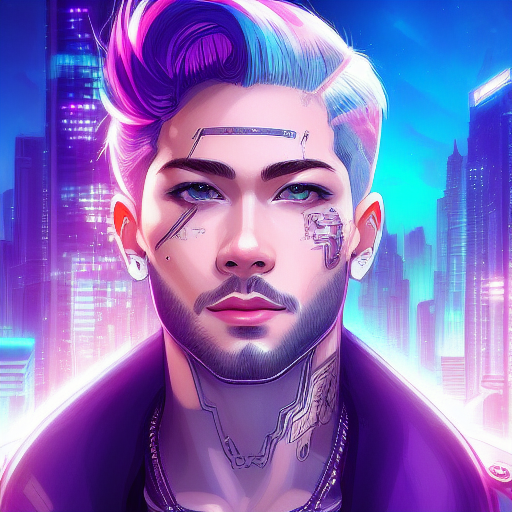

images/outputs/3417223905163862_2023-01-14 16:58:38.png



  0%|          | 0/20 [00:00<?, ?it/s]

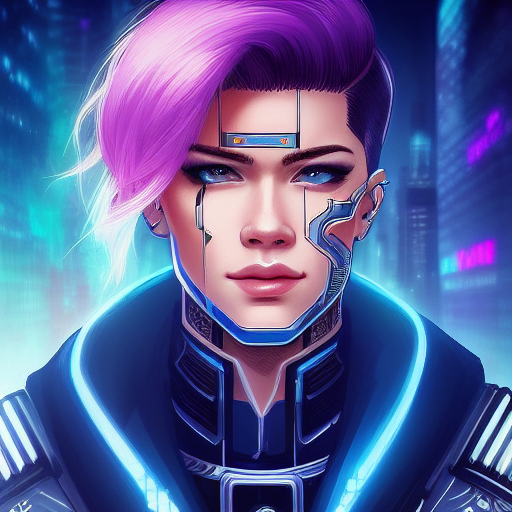

images/outputs/3860989078572657_2023-01-14 16:58:42.png


Seeds for generating images: [3417223905163862, 3860989078572657]



In [12]:
import torch
import datetime

from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
model_dir = WEIGHTS_DIR

scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
generator = torch.Generator(device="cuda")
pipe = StableDiffusionPipeline.from_pretrained(model_dir, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
prompt = "photo of cypk style man, handsome detailed face, front view, city background, masterpiece, best quality, highly detailed"
negative_prompt = "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark"

num_images = 2
seeds = []
for _ in range(num_images):
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=512,
        width=512,
        num_images_per_prompt=1,
        num_inference_steps=20,
        guidance_scale=7.5,
        generator = generator
    ).images[0]
    display(image)
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)
    
# print(seeds)
print(f"\nSeeds for generating images: {seeds}\n")

  0%|          | 0/20 [00:00<?, ?it/s]

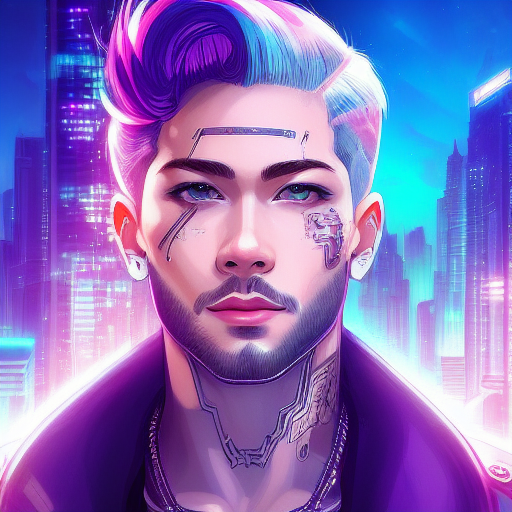

In [13]:
# Comment below codes, if you don't want to produce the same images again
seed = seeds[0] # use the first seed
generator.manual_seed(seed)
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=512,
    width=512,
    num_images_per_prompt=1,
    num_inference_steps=20,
    guidance_scale=7.5,
    generator = generator
).images[0]
display(image)

### 1.7 Use scripts to convert weights to ckpt to use in web UIs like AUTOMATIC1111
* For how to use "Stable Diffusion web UI" of AUTOMATIC1111, please refer to this [repo](https://github.com/AUTOMATIC1111/stable-diffusion-webui)
* DreamBooth plugin can also be implemented for "Stable Diffusion web UI" to fine tune the model
* You can also use other methods provided by webUI to fine tune the model.

In [14]:
# uncomment below codes if you want to generate ckpt file for web UI

# !wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
# ckpt_path = WEIGHTS_DIR + "/model.ckpt"
# half_arg = ""
# #@markdown  Whether to convert to fp16, takes half the space (2GB).
# fp16 = False #@param {type: "boolean"}
# if fp16:
#     half_arg = "--half"
# !python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
# print(f"[*] Converted ckpt saved at {ckpt_path}")

## 2. SageMaker inference part

### 2.1 Initialize SageMaker inference endpoint

In [15]:
!python -m pip install -U awscli
!pip install -U sagemaker
!pip install -U boto3

import sagemaker
import boto3
sess = sagemaker.Session()
sagemaker_session_bucket=None

if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()
    
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 111.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 133.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.48
    Uninstalling botocore-1.29.48:
      Successfully uninstalled botocore-1.29.48
  Attempting uninstall: awscli
    Found existing installation: awscli 1.27.48
    Uninstalling awscli-1.27.48:
      Successfully uninstalled awscli-1.27.48
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.29.50 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https:

### 2.2 Create "inference.py" script for SageMaker

In [16]:
!mkdir -p $WEIGHTS_DIR/code

In [17]:
%%writefile $WEIGHTS_DIR/code/requirements.txt
diffusers
transformers>=4.25.1

Writing stable_diffusion_weights/dreambooth_fine_tune/1000/code/requirements.txt


In [18]:
%%writefile $WEIGHTS_DIR/code/inference.py
import base64
import torch
from io import BytesIO
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler


def model_fn(model_dir):
    
    # Load stable diffusion and move it to the GPU
    scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
    pipe = StableDiffusionPipeline.from_pretrained(model_dir, scheduler=scheduler, torch_dtype=torch.float16)
    pipe = pipe.to("cuda")

    return pipe


def encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale):
    
    generator = generator.manual_seed(seed)
    generated_images = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=height,
        width=width,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator = generator
    )["images"][0]
    buffered = BytesIO()
    generated_images.save(buffered, format="PNG")
    encoded_image_response = base64.b64encode(buffered.getvalue()).decode()
    
    return encoded_image_response


def predict_fn(data, pipe):
    
    generator = torch.Generator(device="cuda")
    
    # get prompt & parameters
    prompt = data.pop("prompt", "")
    negative_prompt = data.pop("negative_prompt", "")
    # set valid HP for stable diffusion
    height = data.pop("height", 512)
    width = data.pop("width", 512)
    num_inference_steps = data.pop("num_inference_steps", 20)
    guidance_scale = data.pop("guidance_scale", 7.5)
    num_images_per_prompt = data.pop("num_images_per_prompt", 2)
    seed = data.pop("seed", "")
    
    seeds = []
    encoded_images = []
    
    # run generation with parameters
    if seed:
        seeds.append(seed)
        encoded_image_rt = encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale)
        encoded_images.append(encoded_image_rt)
        for _ in range(num_images_per_prompt-1):
            seed=seed+1
            seeds.append(seed)
            encoded_image_rt = encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale)
            encoded_images.append(encoded_image_rt)
    else:
        for _ in range(num_images_per_prompt):
            seed = generator.seed()
            seeds.append(seed)
            encoded_image_rt = encoded_image(generator, seed, pipe, prompt, negative_prompt, height, width, num_inference_steps, guidance_scale)
            encoded_images.append(encoded_image_rt)

    # create response
    return {"generated_images": encoded_images, "seeds": seeds}

Writing stable_diffusion_weights/dreambooth_fine_tune/1000/code/inference.py


### 2.3 Package SageMaker model.tar.gz artifact

In [19]:
!tar --exclude *.ckpt --use-compress-program=pigz -pcvf $WEIGHTS_DIR/model.tar.gz -C $WEIGHTS_DIR/ .

./
./unet/
./unet/diffusion_pytorch_model.bin
./unet/config.json
./code/
./code/requirements.txt
./code/inference.py
./text_encoder/
./text_encoder/config.json
./text_encoder/pytorch_model.bin
./model.tar.gz
tar: ./model.tar.gz: file changed as we read it
./vae/
./vae/diffusion_pytorch_model.bin
./vae/config.json
./args.json
./tokenizer/
./tokenizer/tokenizer_config.json
./tokenizer/special_tokens_map.json
./tokenizer/vocab.json
./tokenizer/merges.txt
./scheduler/
./scheduler/scheduler_config.json
./model_index.json
tar: .: file changed as we read it


### 2.4 Upload the model to S3 bucket

In [20]:
from sagemaker.s3 import S3Uploader
s3_model_uri=S3Uploader.upload(local_path=f"{WEIGHTS_DIR}/model.tar.gz", desired_s3_uri=f"s3://{sess.default_bucket()}/stablediffusion-dreambooth/g4dn")

### 2.5 Deploy the model to SageMaker

In [21]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,      # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.17",  # transformers version used
   pytorch_version="1.10",       # pytorch version used
   py_version='py38',            # python version used
)

# deploy the endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge"
    )

----------!

### 2.6 Generate images using SageMaker inference endpoint

In [22]:
from PIL import Image
from io import BytesIO
import base64
import datetime

# helper decoder
def decode_base64_image(image_string):
    base64_image = base64.b64decode(image_string)
    buffer = BytesIO(base64_image)
    return Image.open(buffer)

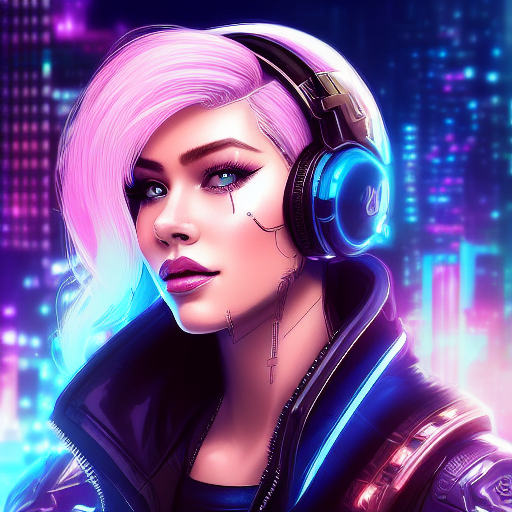

images/outputs/8896181502667759_2023-01-14 17:07:14.324756.png



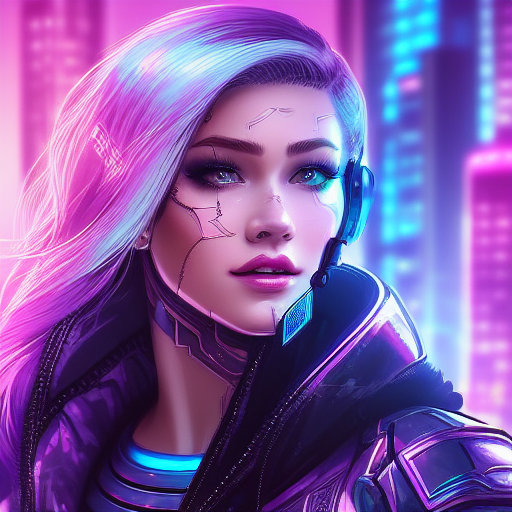

images/outputs/2142416576429893_2023-01-14 17:07:14.947116.png


Seeds for generating images: [8896181502667759, 2142416576429893]

Images saved in: s3://sagemaker-us-east-1-091166060467/stablediffusion-dreambooth/g4dn/images_output



In [23]:
# run prediction
response = predictor.predict(data={
    "prompt": "photo of cypk style girl, pretty detailed face, front view, city background, masterpiece, best quality, highly detailed",
    "negative_prompt": "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark",
    "height" : 512,
    "width" : 512,
    "num_images_per_prompt" : 2,
    # "seed" : 3904759173130859  # uncomment seed and replace with generated one, if you want to produce same
  }
)

# decode images
decoded_images = [decode_base64_image(image) for image in response["generated_images"]]

# visualize generation
i = 0
for image in decoded_images:
    display(image)
    seed = response['seeds'][i]
    i = i+1
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)
    # comment below code if you don't want to save in S3 bucket
    s3_model_uri=S3Uploader.upload(local_path=file_path, desired_s3_uri=f"s3://{sess.default_bucket()}/stablediffusion-dreambooth/g4dn/images_output")

# print(seeds)
print(f"\nSeeds for generating images: {response['seeds']}")
print(f"\nImages saved in: " + f"s3://{sess.default_bucket()}/stablediffusion-dreambooth/g4dn/images_output\n")


### 2.7 Delete model and endpoint

In [24]:
# uncomment below codes if you wanto to delete mode and endpoint for inference
# predictor.delete_model()
# predictor.delete_endpoint()